# Abhängigkeiten in Bezug auf Entwickler:innen und Technologien

Diese Analyse beschäftigt sich mit der Darstellung von Abhängigkeiten in Bezug auf die verwendeten Technologien und die Entwickler:innen, welche sich damit beschäftigen.
Dazu werden für jede Technologie die Entwicklungsanteile der Entwickler:innen jeweils zum Ende der Jahre 2020 und 2021 dargestellt.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dazu werden für alle Entwickler:innen alle Beiträge in Form von Commits und geänderten Codezeilen extrahiert und auf die einzelnen Technologien bezogen. Anhand dieser Daten wird anschließend der jeweilige Entwicklungsanteil pro Technologie und Person berechnet. Dieser entspricht dem Code Ownership der einzelnen Personen zu dem jeweiligen Zeitpunkt.

Das Code Ownership wird anhand der Anzahl der Commits und geänderten Codezeilen berechnet.
Die entsprechende Formel zu Berechnung des Anteils einer einzelnen Person $P$ zum Zeitpunkt $t$ lautet: 

$
\textrm{Ownership}(P)_t = 
    \frac{
        \frac{\textrm{Commits}(p)_t}{\textrm{Commits} _t}
        +\frac{\textrm{LoCC}(p)_t}{\textrm{LoCC} _t}
    }
    {2}
$

Das Code-Ownership des Teilprojekts ist der maximale Wert aus der Liste der persönlichen Anteile der Beteiligten.

In [1]:
import shared.paths as paths
import shared.locals as locals
from shared.calculation import average
from tinydb.queries import where
from datetime import datetime
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, Project, User

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

technologies = config.technologies
users = database.all(User.LABEL)
projects = database.query(Project.LABEL, where("technologies") != [])

years = [2020, 2021]

addition_result = {year: 
        {technology: 
            {user.id: {"commits": 0, "locc": 0} for user in users}
        for technology in technologies}
    for year in years}

for user in users:
    for project in projects:
        for commit in database.query(Commit.LABEL,
            (where("author_id") == user.id) & (where("project_id") == project.id)):
                for technology in project.technologies:
                    if (commit_year := datetime.utcfromtimestamp(commit.timestamp).year) == 2020:
                        for year in years:
                            addition_result[year][technology][user.id]["commits"] += 1
                            addition_result[year][technology][user.id]["locc"] += commit.changed_loc
                    elif commit_year == 2021:
                        addition_result[commit_year][technology][user.id]["commits"] += 1
                        addition_result[commit_year][technology][user.id]["locc"] += commit.changed_loc

results = {year: 
        {technology: 
            {user.id: {"commits": 0, "locc": 0} for user in users}
        for technology in technologies}
    for year in years}

for year in years:
    for technology in technologies:
        total_commits = sum([user["commits"] for user in addition_result[year][technology].values()])
        total_locc = sum([user["locc"] for user in addition_result[year][technology].values()])
        
        for user in users:
            contribution = average([
                addition_result[year][technology][user.id]["commits"] / total_commits,
                addition_result[year][technology][user.id]["locc"] / total_locc,
            ])
            results[year][technology][user.id] = contribution

## Visualisierung der Daten

Im zweiten Schritt werden die Daten jeweils für die Zeitpunkte zum Ende der Jahre 2020 und 2021 in Balkendiagrammen dargestellt.

Python

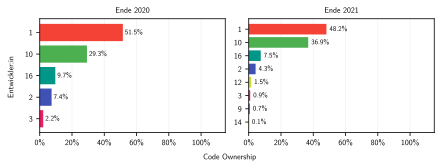

Terraform

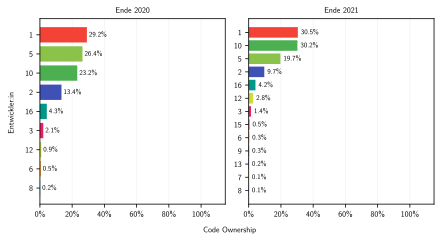

CloudFormation

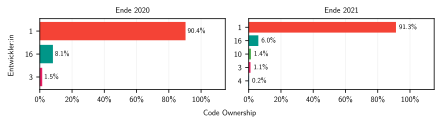

ARM

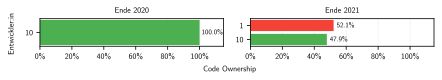

Docker

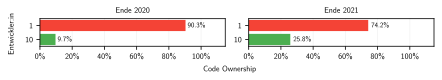

Vue.js

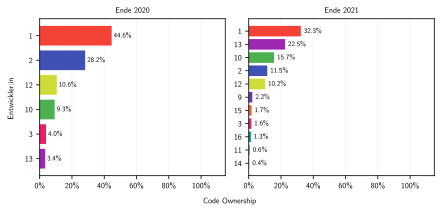

TypeScript

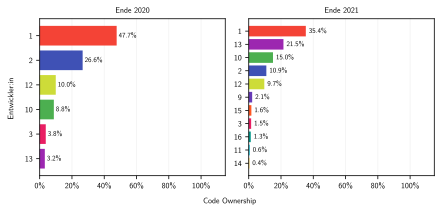

DynamoDB

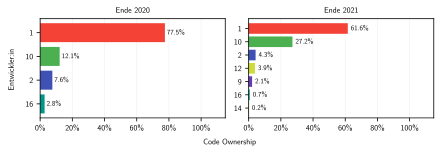

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from IPython.display import display, HTML, Markdown

plt.rc("font", **locals.FONT)

for technology in technologies:

    result_2020 = dict(sorted({value*100: user 
        for user, value in results[2020][technology].items() if value > 0}.items()))
    values_2020 = list(result_2020.keys())
    positions_2020 = [i for i in range(len(values_2020))]
    labels_2020 = [locals.USERS[user]["id"] for user in result_2020.values()]

    result_2021 = dict(sorted({value*100: user 
        for user, value in results[2021][technology].items() if value > 0}.items()))
    values_2021 = list(result_2021.keys())
    positions_2021 = [i for i in range(len(values_2021))]
    labels_2021 = [locals.USERS[user]["id"] for user in result_2021.values()]

    height = 0.6 + len(result_2021) * 0.2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(locals.TEXTWIDTH, height))

    ax1.barh(positions_2020, values_2020, align="center",
        color=[locals.USERS[user]["color"] for user in result_2020.values()])
    ax1.set_yticks(positions_2020, labels=labels_2020)
    ax1.xaxis.set_major_formatter(mticker.PercentFormatter(100.0))
    ax1.set_title("Ende 2020", fontsize=locals.FONT["size"])
    ax1.bar_label(ax1.containers[0], padding=2, fmt="%.1f%%", fontsize=locals.FONT["size"]-1)
    ax1.set_xlim(right=115)
    ax1.set_xticks([i for i in range(0, 101, 20)])
    ax1.grid(axis="x", color=locals.GRID_GRAY)
    ax1.set_axisbelow(True)

    ax2.barh(positions_2021, values_2021, align='center',
        color=[locals.USERS[user]["color"] for user in result_2021.values()])
    ax2.set_yticks(positions_2021, labels=labels_2021)
    ax2.xaxis.set_major_formatter(mticker.PercentFormatter(100.0))
    ax2.set_title("Ende 2021", fontsize=locals.FONT["size"])
    ax2.bar_label(ax2.containers[0], padding=3, fmt="%.1f%%", fontsize=locals.FONT["size"]-1)
    ax2.set_xlim(right=115)
    ax2.set_xticks([i for i in range(0, 101, 20)])
    ax2.grid(axis="x", color=locals.GRID_GRAY)
    ax2.set_axisbelow(True)

    fig.text(0.5, -0.02, "Code Ownership", ha="center")
    fig.text(-0.02, 0.5, "Entwickler:in", va="center", rotation="vertical")
    
    display(Markdown(locals.TECHNOLOGIES[technology]["id"]))
    plt.tight_layout()
    plt.show()

## Erstellung der Wertetabellen

Als letzter Schritt werden die entsprechenden Wertetabellen angelegt.

In [3]:
from tabulate import tabulate

display(Markdown("**Wertetabellen**"))

for technology in technologies:
    display(Markdown(locals.TECHNOLOGIES[technology]["id"]))

    table_headers = ["Entwickler:in"]
    table_headers.extend([year for year in years])

    table_rows = []

    for user in users:
        row = [locals.USERS[user.id]["id"]]

        for year in years:
            row.append(results[year][technology][user.id])
        
        if row[1] or row[2]:
            for index, value in enumerate(row[1:]):
                row[index + 1] = f"{value:.3f}" if value != 0 else "-"
            table_rows.append(row)

    display(HTML(tabulate(headers=table_headers,
        tabular_data=table_rows,
        tablefmt="html", stralign="center", numalign="center")))

**Wertetabellen**

Python

Entwickler:in,2020,2021
1,0.515,0.482
2,0.074,0.043
3,0.022,0.009
9,-,0.007
10,0.293,0.369
12,-,0.015
14,-,0.001
16,0.097,0.075


Terraform

Entwickler:in,2020,2021
1,0.292,0.305
2,0.134,0.097
3,0.021,0.014
5,0.264,0.197
6,0.005,0.003
7,-,0.001
8,0.002,0.001
9,-,0.003
10,0.232,0.302
12,0.009,0.028


CloudFormation

Entwickler:in,2020,2021
1,0.904,0.913
3,0.015,0.011
4,-,0.002
10,-,0.014
16,0.081,0.06


ARM

Entwickler:in,2020,2021
1,-,0.521
10,1.000,0.479


Docker

Entwickler:in,2020,2021
1,0.903,0.742
10,0.097,0.258


Vue.js

Entwickler:in,2020,2021
1,0.446,0.323
2,0.282,0.115
3,0.040,0.016
9,-,0.022
10,0.093,0.157
11,-,0.006
12,0.106,0.102
13,0.034,0.225
14,-,0.004
15,-,0.017


TypeScript

Entwickler:in,2020,2021
1,0.477,0.354
2,0.266,0.109
3,0.038,0.015
9,-,0.021
10,0.088,0.15
11,-,0.006
12,0.100,0.097
13,0.032,0.215
14,-,0.004
15,-,0.016


DynamoDB

Entwickler:in,2020,2021
1,0.775,0.616
2,0.076,0.043
9,-,0.021
10,0.121,0.272
12,-,0.039
14,-,0.002
16,0.028,0.007
